<a href="https://colab.research.google.com/github/PetrovAlexey/GenerativeModels/blob/main/homework_part1_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1. PixelCNN

During this homework, you will train PixleCNN models on the shapes dataset and MNIST. In addition, we will extend to modelling with class conditioning.

- **Task 1 (10 points): PixelCNN on binary MNIST**
- Task 2 (10 points): Conditional PixelCNN
- \* Bonus (10+++ points)

## Task 1. PixelCNN on Shapes and MNIST

In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images

Recap:

$$Mask_a
=
\begin{bmatrix}
1 & 1 & 1 \\
1 & 0 & 0 \\
0 & 0 & 0 \\
\end{bmatrix}$$

$$Mask_b
=
\begin{bmatrix}
1 & 1 & 1 \\
1 & 1 & 0 \\
0 & 0 & 0 \\
\end{bmatrix}$$

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network. 

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import math
from sklearn.model_selection import train_test_split
import random

%matplotlib inline

In [20]:
import pickle
from torchvision.utils import make_grid


def show_samples(samples, fname=None, nrow=10, title='Samples'):
    samples = (torch.FloatTensor(samples)).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

    if fname is not None:
        savefig(fname)
    else:
        plt.show()
        

def load_data(fname, binarize=True, include_labels=False):
    with open(fname, 'rb') as data_file:
        data = pickle.load(data_file)
    
    if include_labels:
        return (data['train'] > 127.5), (data['test'] > 127.5), data['train_labels'], data['test_labels']
    
    return (data['train'] > 127.5), (data['test'] > 127.5)


class SimpleDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y
        
        assert len(X) == len(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

First of all, we need to modify `Conv2d` with masking

In [29]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.ones(self.weight.data.size()))
        self.create_mask(mask_type)

    def forward(self, x):
        """
        x: (N, C_in, H_in, W_in) torch.Tensor
        Returns
          - out (N, C_out, H_out, W_out) should be conv2d(x, weight * mask) + bias 
        """
        self.weight.data *= self.mask
        return super().forward(x)
    
    def create_mask(self, mask_type):
        assert mask_type == 'A' or mask_type == 'B'
        k = self.kernel_size[0]
        y, x = self.mask.size(2) // 2, self.mask.size(3) // 2
        self.mask[:, :, y + 1:, :].zero_()
        self.mask[:, :, y:, (mask_type == 'A' and x or x + 1):].zero_()

In [31]:
convA = MaskedConv2d('A', 1, 1, kernel_size=3)
convB = MaskedConv2d('B', 1, 1, kernel_size=3)
assert np.allclose(convA.mask.view(-1), [1., 1., 1., 1., 0., 0., 0., 0., 0.], atol=1e-6)
assert np.allclose(convB.mask.view(-1), [1., 1., 1., 1., 1., 0., 0., 0., 0.], atol=1e-6)

In [130]:
class PixelCNN(nn.Module):
    def __init__(self, input_shape, n_colors=2, n_filters=64,
               kernel_size=7, n_layers=5):
        super().__init__()
        assert n_layers >= 2
        n_channels = input_shape[0]
        
        self.n_layers = n_layers
        self.input_shape = input_shape
        self.n_channels = n_channels
        self.n_colors = n_colors
        self.discrete_levels = 8
        
        self.in_conv = MaskedConv2d('A', 1, 2 * n_filters, 7, padding=3, bias=False)
        self.in_bn = nn.BatchNorm2d(2 * n_filters)
        for r in range(1, n_layers + 1):
            self.add_module('layer' + str(r), MaskedConv2d('B', 2*n_filters, 2*n_filters, 5, padding=2, bias=False))
        
        self.out_conv1 = MaskedConv2d('B', 2 * n_filters, n_filters, 3, padding=1, bias=False)
        self.out_bn1 = nn.BatchNorm2d(n_filters)
        self.out_conv2 = nn.Conv2d(n_filters, self.discrete_levels, 1)
        
    def forward(self, x, cond=None):
        batch_size = x.shape[0]
        x = (x.float() / (self.n_colors - 1) - 0.5) / 0.5
        x = self.in_bn(self.in_conv(x))
        for r in range(1, self.n_layers + 1):
            x = getattr(self, 'layer' + str(r))(x)
        x = self.out_bn1(self.out_conv1(F.relu(x)))
        x = self.out_conv2(F.relu(x))
        return x

    def loss(self, x):
        discrete_x = x.clone().squeeze(1).mul_(self.discrete_levels - 1).round_().long()
        x_hat = model(x)
        loss = F.cross_entropy(x_hat, discrete_x.cuda())
        return loss

    def sample(self, n):
        samples = torch.zeros(n, *self.input_shape).cuda()
        with torch.no_grad():
            for r in range(self.input_shape[1]):
                for c in range(self.input_shape[2]):
                    logits = self.forward(samples)[:, :, r, c]
                    probs = F.softmax(logits, dim=1)
                    samples[:, k, r, c] = torch.multinomial(probs, 1).squeeze(-1)
        return samples.permute(0, 2, 3, 1).cpu().numpy()


Feel free to use and modify this train loop. You may want to show some logs or sampling results during training

In [165]:
def train(model, train_loader, optimiser):
    model.train()
    train_losses = []
    for i, (x, _) in enumerate(train_loader):
        x = x.cuda()
        x = x.float()
        optimiser.zero_grad()
        loss = model.loss(x)
        loss.backward()
        optimiser.step()
        train_losses.append(loss.item())
    return train_losses

def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i, (x, _) in enumerate(data_loader):
            x = x.cuda()
            x = x.float()
            loss = model.loss(x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()


def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = [eval_loss(model, test_loader)]
    for epoch in range(epochs):
        print(f'epoch {epoch} started')
        model.train()
        train_losses.extend(train(model, train_loader, optimizer))
        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)
        print('train loss: {}, test_loss: {}'.format(np.mean(train_losses[-1000:]), 
                                                     test_losses[-1]))

    return train_losses, test_losses


def train_model(train_data, test_data, train_labels, test_labels, model):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    model: nn.Model item, should contain function loss and accept
    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - trained model
    """
    train_args = {}
    train_args["epochs"] = 10
    train_args["lr"] = 1e-3
    batch_size = 64

    train_dataset = SimpleDataset(train_data, train_labels)
    test_dataset = SimpleDataset(test_data, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader, train_args)
    return train_losses, test_losses, model

### First dataset: **Shapes** (5 points)

In [166]:
# For colab users: download file
! wget https://github.com/egiby/Generative-Models-MIPT/raw/hw1/module1-likelihood/shapes.pkl

--2021-04-04 10:11:10--  https://github.com/egiby/Generative-Models-MIPT/raw/hw1/module1-likelihood/shapes.pkl
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/egiby/Generative-Models-MIPT/hw1/module1-likelihood/shapes.pkl [following]
--2021-04-04 10:11:10--  https://raw.githubusercontent.com/egiby/Generative-Models-MIPT/hw1/module1-likelihood/shapes.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6108167 (5.8M) [application/octet-stream]
Saving to: ‘shapes.pkl.13’

shapes.pkl.13       100%[===================>]   5.83M  --.-KB/s    in 0.1s    

2021-04-04 10:11:10 (41.7 MB/s) - ‘shapes.p

In [167]:
shapes_train, shapes_test, train_labels, test_labels = load_data('./shapes.pkl', include_labels = True)

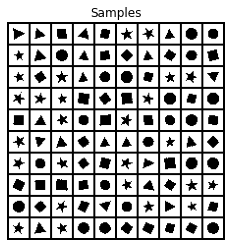

In [168]:
show_samples(shapes_train[:100])

In [169]:
shapes_train = np.swapaxes(shapes_train, 1, 3)
shapes_test = np.swapaxes(shapes_test, 1, 3)

In [170]:
H, W, _ = shapes_train[0].shape
model = PixelCNN((1, H, W)).cuda()
train_losses, test_losses, shapes_model = train_model(shapes_train, shapes_test, train_labels, test_labels, model)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 started
train loss: 0.38923625410334467, test_loss: 0.12281712889671326
epoch 1 started
train loss: 0.2407360428178603, test_loss: 0.07620183378458023
epoch 2 started
train loss: 0.1839322202547562, test_loss: 0.062022700905799866
epoch 3 started
train loss: 0.15320351790705342, test_loss: 0.05925657972693443
epoch 4 started
train loss: 0.1336335625888014, test_loss: 0.05245554819703102
epoch 5 started
train loss: 0.12005528058392016, test_loss: 0.04957086965441704
epoch 6 started
train loss: 0.06471029020100832, test_loss: 0.048529960215091705
epoch 7 started
train loss: 0.05649015840142965, test_loss: 0.048951517790555954
epoch 8 started
train loss: 0.05231939646601677, test_loss: 0.0463971346616745
epoch 9 started
train loss: 0.04959187534078956, test_loss: 0.046727847307920456


In [171]:
def show_train_plots(train_losses, test_losses, title):
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label='train loss')
    plt.plot(x_test, test_losses, label='test loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('NLL')
    plt.show()

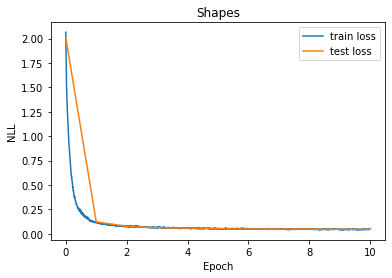

In [172]:
show_train_plots(train_losses, test_losses, 'Shapes')

In [184]:
def show_result_samples(samples, fname=None, nrow=10, title='Samples'):
    samples = (torch.FloatTensor(samples))
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)
    plt.imshow(grid_img.permute(2, 1, 0))
    plt.axis('off')

    if fname is not None:
        savefig(fname)
    else:
        plt.show()

def sample(model):
    model.eval()
    with torch.no_grad():
        samples = torch.zeros(100, 1, 28, 28).cuda()
        for i in range(28):
            for j in range(28):
                out = model(samples)
                probs = F.softmax(out[:, :, i, j], dim=1)
                samples[:, :, i, j] = torch.multinomial(probs, 1).float() / (8 - 1)

        show_result_samples(samples.cpu())

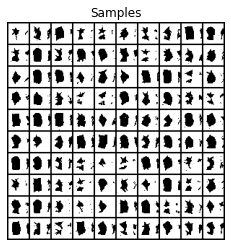

In [186]:
sample(shapes_model)

### Second dataset: MNIST (5 points)

In [175]:
# For colab users: download file
! wget https://github.com/egiby/Generative-Models-MIPT/raw/hw1/module1-likelihood/mnist.pkl

--2021-04-04 10:14:26--  https://github.com/egiby/Generative-Models-MIPT/raw/hw1/module1-likelihood/mnist.pkl
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/egiby/Generative-Models-MIPT/hw1/module1-likelihood/mnist.pkl [following]
--2021-04-04 10:14:26--  https://raw.githubusercontent.com/egiby/Generative-Models-MIPT/hw1/module1-likelihood/mnist.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55440407 (53M) [application/octet-stream]
Saving to: ‘mnist.pkl.1’

mnist.pkl.1         100%[===================>]  52.87M   136MB/s    in 0.4s    

2021-04-04 10:14:27 (136 MB/s) - ‘mnist.pkl.1’ s

In [176]:
mnist_train, mnist_test, train_labels, test_labels = load_data('./mnist.pkl', include_labels = True)

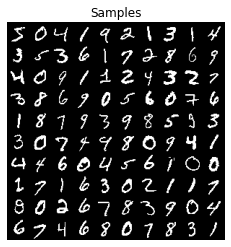

In [177]:
show_samples(mnist_train[:100])

In [179]:
mnist_train = np.swapaxes(mnist_train, 1, 3)
mnist_test = np.swapaxes(mnist_test, 1, 3)

In [181]:
H, W, _ = mnist_train[0].shape
model = PixelCNN((1, H, W)).cuda()
train_losses, test_losses, mnist_model = train_model(mnist_train, mnist_test, train_labels, test_labels, model)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 started
train loss: 0.16860514917394012, test_loss: 0.08882644772529602
epoch 1 started
train loss: 0.08596966326981782, test_loss: 0.08425328135490417
epoch 2 started
train loss: 0.0833657518401742, test_loss: 0.08175386488437653
epoch 3 started
train loss: 0.08200704496353865, test_loss: 0.08105815201997757
epoch 4 started
train loss: 0.08123437432199716, test_loss: 0.0810001865029335
epoch 5 started
train loss: 0.0806521062925458, test_loss: 0.08022592216730118
epoch 6 started
train loss: 0.08009337978810072, test_loss: 0.07984638214111328
epoch 7 started
train loss: 0.07971230823546648, test_loss: 0.0792892575263977
epoch 8 started
train loss: 0.07934593591839074, test_loss: 0.07900794595479965
epoch 9 started
train loss: 0.07902545491605997, test_loss: 0.07879467308521271


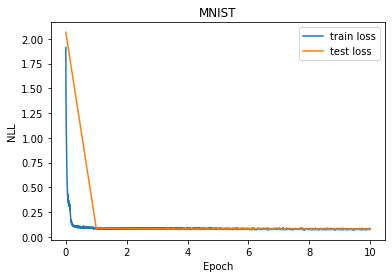

In [182]:
show_train_plots(train_losses, test_losses, 'MNIST')

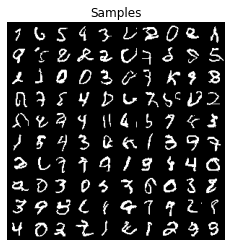

In [185]:
sample(mnist_model)